In [2]:
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor
import optuna
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/IMDb Movies India.csv',encoding='ISO-8859-1').drop(columns='Name')

df.dropna(inplace=True)

In [5]:
df.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [7]:
# Find info about the columns
print(df.shape)
print("-"*60)
print(df.isna().sum())
print("-"*60)
print(df.duplicated().sum())
print("-"*60)
df.info()

(5659, 9)
------------------------------------------------------------
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64
------------------------------------------------------------
0
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [8]:
df.nunique()

Year          91
Duration     174
Genre        376
Rating        83
Votes       2027
Director    2431
Actor 1     1960
Actor 2     2321
Actor 3     2556
dtype: int64

In [9]:
# Remove () and convert dtype if year to int
df['Year'] = df['Year'].str.replace('(','')
df['Year'] = df['Year'].str.replace(')','').astype(int)

df['Duration'] = df['Duration'].str.split(' ',expand=True)[0].astype(float)

df['Votes'] = df['Votes'].str.replace(',','').astype(int)

df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,2015,115.0,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,2001,153.0,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [10]:
director_avg_rating = {}
for index, row in df.iterrows():
    director = row['Director']
    rating = row['Rating']
    if director in director_avg_rating:
        director_avg_rating[director]['sum'] += rating
        director_avg_rating[director]['count'] += 1
    else:
        director_avg_rating[director] = {'sum': rating, 'count': 1}

df['Director Average Rating'] = df['Director'].apply(lambda x: director_avg_rating[x]['sum'] / director_avg_rating[x]['count'])

In [11]:
# add a column ''ead actor average rating'
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}

def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)

In [12]:
df['Genre1'] = df.Genre.str.split(',',expand=True)[0]
df['Genre2'] = df.Genre.str.split(',',expand=True)[1]
df['Genre3'] = df.Genre.str.split(',',expand=True)[2]

In [13]:
df = df.drop(columns=['Genre','Director','Actor 1','Actor 2','Actor 3'])

In [14]:
df.shape[0]

5659

In [15]:
print(df.shape)
print(df.isna().sum())
df = df.fillna(0)

for i in df.index:
    if df.at[i, 'Genre2'] == 0:
        df.at[i, 'Genre2'] = df.at[i, 'Genre1']
    elif df.at[i, 'Genre3'] == 0:
        df.at[i, 'Genre3'] = df.at[i, 'Genre2']
print(df.isna().sum())


(5659, 9)
Year                            0
Duration                        0
Rating                          0
Votes                           0
Director Average Rating         0
Lead Actor Average Rating       0
Genre1                          0
Genre2                       1658
Genre3                       3340
dtype: int64
Year                         0
Duration                     0
Rating                       0
Votes                        0
Director Average Rating      0
Lead Actor Average Rating    0
Genre1                       0
Genre2                       0
Genre3                       0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       5659 non-null   int64  
 1   Duration                   5659 non-null   float64
 2   Rating                     5659 non-null   float64
 3   Votes                      5659 non-null   int64  
 4   Director Average Rating    5659 non-null   float64
 5   Lead Actor Average Rating  5659 non-null   float64
 6   Genre1                     5659 non-null   object 
 7   Genre2                     5659 non-null   object 
 8   Genre3                     5659 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 571.1+ KB


In [17]:
for col in ['Genre1', 'Genre2', 'Genre3']:
    df[col], _ = pd.factorize(df[col])

df.head()

,Year,Duration,Rating,Votes,Director Average Rating,Lead Actor Average Rating,Genre1,Genre2,Genre3
1,2019,109.0,7.0,8,7.000000,6.850000,0,0,0
3,2019,110.0,4.4,35,4.400000,5.420000,1,1,1
5,1997,147.0,4.7,827,5.313333,4.788889,1,2,2
6,2005,142.0,7.4,1086,7.383333,5.435000,0,1,3
8,2012,82.0,5.6,326,5.600000,5.600000,2,3,4


In [18]:
target = 'Rating'
X = df.drop(columns=[target,'Duration'])
y = df[target]

In [19]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [22]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    xgb = XGBRegressor(**param)

    # Fit the model on training data
    xgb.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
# print("Best trial:")
best_trial = study.best_trial
# print(f"  Value: {best_trial.value}")
print("  Params: ")
# for key, value in best_trial.params.items():
    # print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params

[I 2024-07-01 08:38:38,923] A new study created in memory with name: no-name-82ad09e5-8c2e-4060-a6af-0119f21c65be
[I 2024-07-01 08:38:42,487] Trial 0 finished with value: 0.7599724656441343 and parameters: {'n_estimators': 709, 'max_depth': 9, 'learning_rate': 0.047857451061075675, 'subsample': 0.69107236902244, 'colsample_bytree': 0.7198583076795779, 'reg_alpha': 7.777101910001194, 'reg_lambda': 4.83548098289245}. Best is trial 0 with value: 0.7599724656441343.
[I 2024-07-01 08:38:42,900] Trial 1 finished with value: 0.7653924700446432 and parameters: {'n_estimators': 589, 'max_depth': 4, 'learning_rate': 0.04964966324198142, 'subsample': 0.7686183203576971, 'colsample_bytree': 0.9553373603035228, 'reg_alpha': 9.050468153131618, 'reg_lambda': 4.89247048588636}. Best is trial 1 with value: 0.7653924700446432.
[I 2024-07-01 08:38:43,302] Trial 2 finished with value: 0.763650662729814 and parameters: {'n_estimators': 324, 'max_depth': 6, 'learning_rate': 0.06900694954678246, 'subsample':

  Params: 


In [23]:
xgb_normal = XGBRegressor(**best_params)


xgb_normal.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)],verbose=0)

# Make predictions on the test set
y_pred_test = xgb_normal.predict(X_test)

mae = mean_absolute_error(y_test,y_pred_test)


print("Test MAE:",mae )

Test MAE: 0.4606202651670881


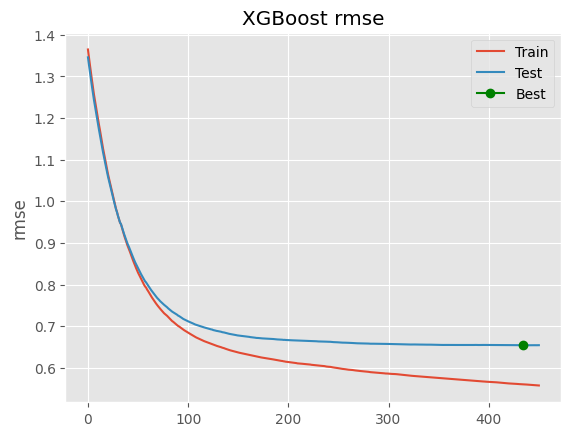

In [24]:
results = xgb_normal.evals_result()
val_rmse = results["validation_1"]['rmse']
best_epopch = min(val_rmse)
i_best_epoch = val_rmse.index(best_epopch)
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot m log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

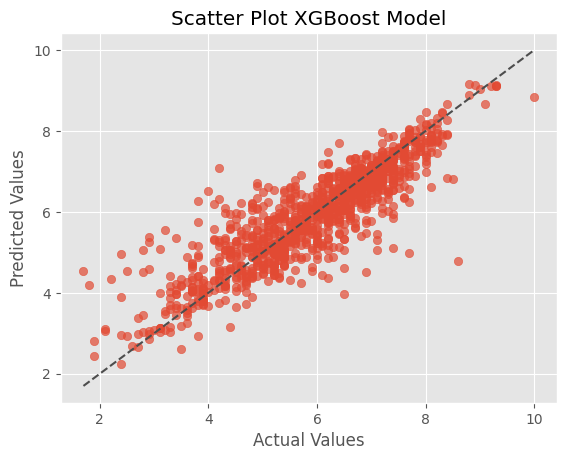

In [25]:
plt.scatter(y_test, y_pred_test, alpha=0.7, label='Real')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], '--', c='.3')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot XGBoost Model')
plt.show()

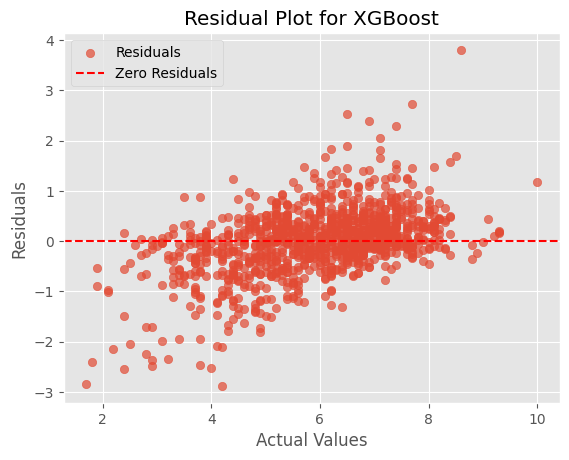

In [26]:
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals, label='Residuals', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost')
plt.legend()
plt.show()

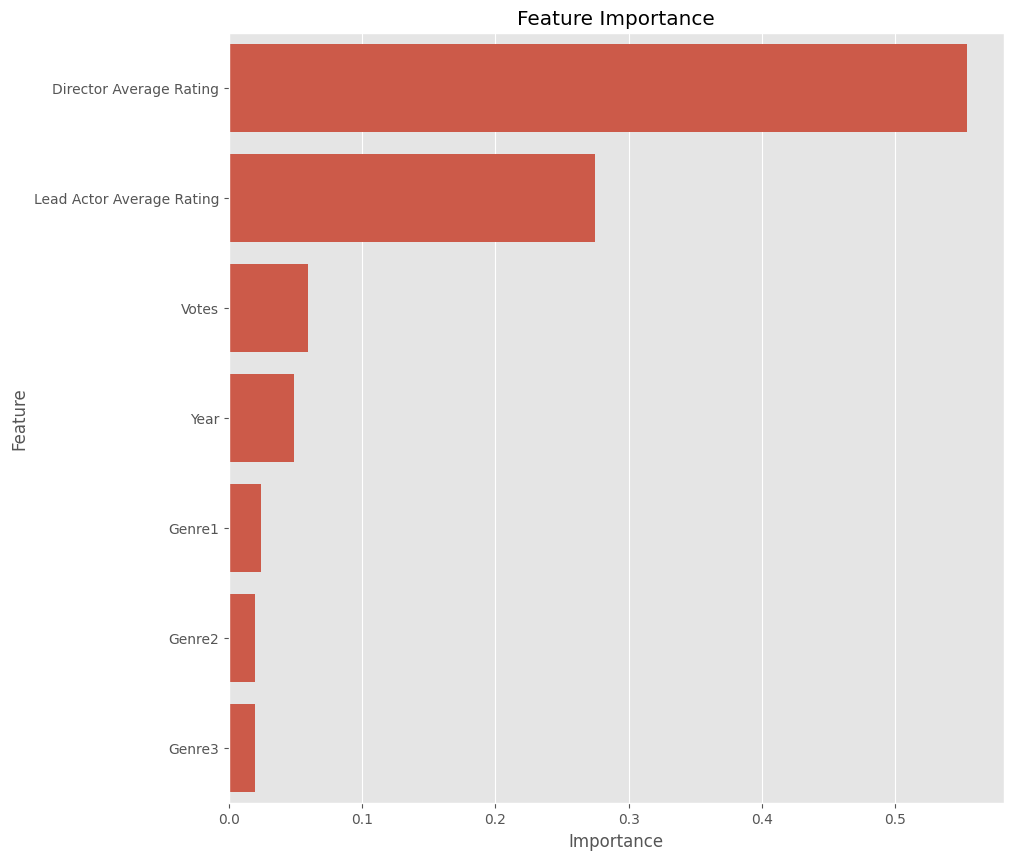

In [27]:
def plot_feature_importance(model, feature_names=None, plot=True):

    feature_importance = model.feature_importances_

    if feature_names is None:
        feature_names = model.feature_name()

    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_feature_importance(xgb_normal,feature_names=df.drop(columns=[target,'Duration']).columns)